Apuntes Curso Machine Learning  
Autor: Pablo Manresa Nebot

Consideraciones iniciales:  

- Dado que este notebook es considerado como una hoja de apuntes personal, he ido apuntando aquellas cosas que necesitaba recordar, o que no tenía del todo claras. Por tanto, hay otras que sí tenía claras, y que por consecuencia he decidido escribir para reducir la extensión de este trabajo.

- Además, como es un cuaderno cuya ejecución secuencial es extremadamente lenta porque se entrenan varias redes, he usado una metodología de ir insertando contenido al final del cuaderno e incluyendo librerías que a priori ya había incluido, pero que tuve que hacer para no ejecutar celdas donde estaban incluidas estas librerías, ya que, estropearía los resultados o, la ejecución podría llevar incluso horas. Adicionalmente, para según qué propósitos, he hecho uso de diversas versiones de librerías como Tensorflow, pudiendo esto provocar que al ejecutar todo el código de golpe (mediante Run all) se produzcan errores.

Explorando las diferenciación automática con tensorflow:

In [ ]:
import tensorflow as tf
import numpy as np
import math

x = tf.Variable(0.)

with tf.GradientTape() as tape:
  y = 2*x+3

graf_of_y_vs_x = tape.gradient(y, x)
graf_of_y_vs_x

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
x2 = tf.Variable(1.)
with tf.GradientTape() as g_tape:
  y2 = 2*x2**3+x2**2+x2+1
graf_of_y2_vs_x2 = g_tape.gradient(y2, x2)
graf_of_y2_vs_x2

<tf.Tensor: shape=(), dtype=float32, numpy=9.0>

Con x siendo un tensor:

In [ ]:
tf.random.set_seed(12)
x3 = tf.Variable(tf.random.uniform((2, 2)))

with tf.GradientTape() as g_tape:
  y3 = 2*x3**3+x3**2+x3+1

graf_of_y3_vs_x3 = g_tape.gradient(y3, x3)
graf_of_y3_vs_x3

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3.3207395, 2.3347995],
       [3.4687505, 3.3697357]], dtype=float32)>

# MLP: Primera aproximación

`Dense()` es equivalente a: $x·w + b$  
W son los pesos, y b el sesgo. Ambos conforman los parámetros entrenables de la red.

In [ ]:
w = tf.Variable(tf.random.uniform((24, 24)))
b = tf.Variable(tf.random.uniform((24, )))

x = tf.Variable(tf.random.uniform((24, 24)))

output = tf.matmul(x, w)+b

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255 
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


# MLP: Segunda aproximación. Red con MLPs.

Se define la clase Dense, la cual será un wrapper para encapsular las operaciones de $activacion(x·w+b)$, así como la inicialización de los pesos y el propio sesgo

In [ ]:
class Dense:
  def __init__(self, input_size, output_size, activation, minval=0.0, maxval=0.1):
    self.activation = activation
    self.input_size = input_size
    self.output_size = output_size

    self.w = tf.Variable(tf.random.uniform( (input_size, output_size),  minval=minval, maxval=maxval))
    self.b = tf.Variable(tf.zeros((output_size, )))

  def __call__(self, input):
    dot_prod = tf.matmul(input, self.w)
    return self.activation(dot_prod+self.b)
  
  @property
  def weights(self):
    return [self.w, self.b]

In [ ]:
class Sequencial:
  def __init__(self, niveles):
    self.niveles = niveles

  def __call__(self, x):
    for nivel in self.niveles:
      x = nivel(x)
    return x

  @property
  def weights(self):
    w = []
    for nivel in self.niveles:
      w = w + nivel.weights
    return w

modelo = Sequencial([
                   Dense(784, 256, tf.nn.relu, 0.0, 0.1),
                   Dense(256, 10, tf.nn.softmax, 0.0, 0.1)
])

In [ ]:
class batch_step:
  def __init__(self, imgs, labels, size=32):
    self.imgs = imgs
    self.labels =  labels
    self.size = size
    self.n_batches = labels.shape[0]//size
    self.current_index = 0
  def next_batch(self):
    batch_imgs = self.imgs[self.current_index : self.current_index+self.size]    
    batch_labels = self.labels[self.current_index : self.current_index+self.size]    
    self.current_index = self.current_index + self.size
    return batch_imgs, batch_labels

## Entrenamiento    
1) Se hacen las predicciones con los datos del batch actual.  
2) Se calcula el error.  
3) Se calcula el gradiente del error con respecto a los pesos.  
4) Se mueven los pesos en dirección contraria a la del gradiente.  

In [ ]:
lr = 1e-2

@tf.function
def train_step(model, imgs, labels):
  with tf.GradientTape() as g_tape:
    y_preds = model(imgs)
    losses = tf.keras.losses.sparse_categorical_crossentropy(labels, y_preds)
    loss_avg = tf.reduce_mean(losses)
  gradients = g_tape.gradient(loss_avg, model.weights)
  
  for grad, w in zip(gradients, model.weights):
    w.assign_sub(grad*lr)

  return loss_avg, y_preds

## Evaluación

Evaluando el modelo completo

In [ ]:
from tqdm import tqdm
tf.config.run_functions_eagerly(True)

@tf.function
def train_full(model, imgs, labels, epochs, batch):
  for epoch in range(epochs):
    batch = batch_step(imgs, labels)
    print("epoch {}/{}".format(epoch+1, epochs))
    for current_batch in tqdm(range(batch.n_batches)):
      imgs_b, labels_b = batch.next_batch()
      loss, y_preds = train_step(model, imgs_b, labels_b)

      if current_batch + 1 == batch.n_batches:
        print("loss {:.2f}. Acc {:.2f} ".format(loss.numpy(), (np.argmax(y_preds.numpy(), axis=-1) == labels_b).mean()))

train_full(modelo, train_images, train_labels, 10, 256)

epoch 1/15


100%|██████████| 1875/1875 [00:31<00:00, 59.27it/s] 


loss 6.09. Acc 0.62 
epoch 2/15


100%|██████████| 1875/1875 [00:14<00:00, 128.34it/s]


loss 3.09. Acc 0.78 
epoch 3/15


100%|██████████| 1875/1875 [00:14<00:00, 126.56it/s]


loss 3.06. Acc 0.81 
epoch 4/15


100%|██████████| 1875/1875 [00:14<00:00, 127.07it/s]


loss 3.07. Acc 0.81 
epoch 5/15


100%|██████████| 1875/1875 [00:14<00:00, 129.70it/s]


loss 0.34. Acc 0.91 
epoch 6/15


100%|██████████| 1875/1875 [00:14<00:00, 132.27it/s]


loss 0.24. Acc 0.94 
epoch 7/15


100%|██████████| 1875/1875 [00:14<00:00, 131.80it/s]


loss 0.20. Acc 0.94 
epoch 8/15


100%|██████████| 1875/1875 [00:14<00:00, 126.46it/s]


loss 0.17. Acc 0.94 
epoch 9/15


100%|██████████| 1875/1875 [00:20<00:00, 90.98it/s]


loss 0.15. Acc 0.97 
epoch 10/15


100%|██████████| 1875/1875 [00:22<00:00, 84.80it/s] 


loss 0.14. Acc 0.97 
epoch 11/15


100%|██████████| 1875/1875 [00:14<00:00, 129.59it/s]


loss 0.12. Acc 0.97 
epoch 12/15


100%|██████████| 1875/1875 [00:14<00:00, 129.51it/s]


loss 0.11. Acc 0.97 
epoch 13/15


100%|██████████| 1875/1875 [00:18<00:00, 103.29it/s]


loss 0.11. Acc 0.97 
epoch 14/15


100%|██████████| 1875/1875 [00:20<00:00, 93.15it/s]


loss 0.10. Acc 0.97 
epoch 15/15


100%|██████████| 1875/1875 [00:25<00:00, 74.25it/s]

loss 0.10. Acc 0.97 


## Predicciones

In [ ]:
preds = modelo(test_images)
(np.argmax(preds.numpy(), axis=-1) == test_labels).mean()

0.9164

In [ ]:
preds_unprob = np.argmax(preds.numpy(), axis=-1)
preds_unprob

array([7, 2, 1, ..., 4, 5, 6])

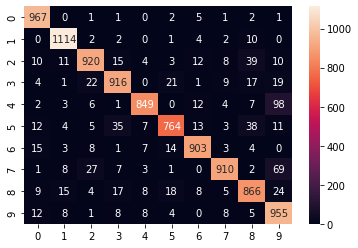

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_true=test_labels, y_pred=preds_unprob)

sns.heatmap(pd.DataFrame(cm, index = np.arange(10), columns=np.arange(10)), annot=True, fmt="g")

# Redes Convolucionales

Redes convolucionales. Dado que con ellas he trabajado bastante, escribiré los aspectos que más interesantes me han parecido y de los que dejar constancia para revisarlo en un futuro, o aquellos, que he necesitado repasar.  
  
  Una red convolucional básica para entender como se funcionan con las imágenes y su dimensión.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

Se cargan el dataset con el fin de conocer su media y desviación típica para poder normalizarlas perdiendo la mínima cantidad de información posible.

In [ ]:
transform = transforms.Compose([
                                 transforms.ToTensor()
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

imgs = torch.stack([img_t for img_t, _ in trainset], dim=-1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
imgs.view(3, -1).mean(dim=-1), imgs.view(3, -1).std(dim=-1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Dimensión de las imágenes del primer batch
next(iter(trainloader))[0].shape[1:]

torch.Size([3, 32, 32])

La primera dimensión corresponde a los canales, por lo que habrá que transponer la matriz o permutar los ejes.

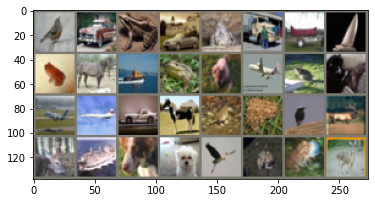

In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
  #img = img/2 + 0.5
  img = img.permute(1,2,0)
  mean = torch.tensor([0.4914, 0.4822, 0.4465])
  std = torch.tensor([0.2470, 0.2435, 0.2616])
  # Se desnormaliza la imagen aplicando las operaciones contrarias a la normalización. La normalización es (img - mean)/std
  im = (img*std)+mean
  # El primer 
  plt.imshow( im )
  plt.show()

imgs, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(imgs))


## Calculando la dimensión de las imágenes en la red

La fórmula para conocer el tamaño de la matriz en una cnn es la siguiente:  
$\text{dimensión espacial}=\frac{(W - K + 2P)}{S} + 1$  
donde:  
   - W es la dimensión de la entrada  
   - K es el tamaño del campo receptivo o kernel  
   - P el tamaño de cero padding. Si no hay zero padding, entonces P = 0.
   - S el stride.  
     
El cero padding se calcula como $P = \frac{(K-1)}{2}$ Siendo K el campo receptivo.

## Definición de la arquitectura

Se crea la red convolucional:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class neural_net(nn.Module):
  def __init__(self, verbose=False):
    super().__init__()

    self.verbose = verbose
    self.cv1 = nn.Conv2d(3, 32, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.cv2 = nn.Conv2d(32, 64, 5)
    self.pool2 = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(64*5*5, 200)
    self.fc2 = nn.Linear(200, 10)
  def forward(self, x):
    shapes = []

    shapes.append(x.shape)

    x = self.cv1(x)
    shapes.append(x.shape)

    x = self.pool(F.relu(x))
    shapes.append(x.shape)

    x = self.cv2(x)
    shapes.append(x.shape)

    x = self.pool2(F.relu(x))
    shapes.append(x.shape)

    x = x.view(x.size(0), -1)
    shapes.append(x.shape)

    x = F.relu(self.fc1(x))
    shapes.append(x.shape)

    x = self.fc2(x)
    shapes.append(x.shape)
    
    if self.verbose:
      for shape in shapes:
        print(shape)

    return F.softmax(x, dim=1)

net = neural_net(True)
shapes = net(torch.randn(32, 3, 32, 32))
print()

torch.Size([32, 3, 32, 32])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 14, 14])
torch.Size([32, 64, 10, 10])
torch.Size([32, 64, 5, 5])
torch.Size([32, 1600])
torch.Size([32, 200])
torch.Size([32, 10])



- Imagen de entrada 32x32x3 -> capa cnn1 Input: 32. Kernel: 5. Padding: "valid", es decir, no cero. Stride: 1. Resultado: ((32-5)/1)+1 = 27+1 = 28.  
- MaxPooling: Kernel: 2, stride: 2. -> 28/2 = 14
- Capa cnn2: 14-5 + 1 = 10
- MaxPooling: Kernel: 2, stride: 2. -> 10/2 = 5
- Flatten: (5, 5, 64) = 5x5x64 = (1600)
- Dense1: input 1600, output: 200
- Dense2: input 200, output: 10  
Por motivo obvios se ha omitido la dimensión del tamaño de batch, ya que permanece constante en función del tamaño del mismo.

Se define la función de pérdida y el optimizador:

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Entrenamiento
Se entrena la red durante 10 epochs

In [ ]:
net = neural_net()
epochs = 10
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
net = net.to(device)
for epoch in range(epochs):
  rloss = 0.0
  for index, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = data[0].to(device=device)
    labels = data[1].to(device=device)
    output = net(inputs)

    optimizer.zero_grad()

    
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    rloss = loss.item()

    if index % 1000 == 0:
      print(epoch+1, rloss/1000)
      rloss = 0.0

1 0.0023024790287017823
1 0.0023038246631622316
2 0.002303077220916748
2 0.0023028035163879393
3 0.002305097818374634
3 0.0023016965389251708
4 0.002302170276641846
4 0.002302936315536499
5 0.002302989721298218
5 0.002301095724105835
6 0.002299858331680298
6 0.0023037352561950685
7 0.0023024389743804934
7 0.0023038642406463623
8 0.0023031535148620606
8 0.0023015246391296386
9 0.0023033943176269532
9 0.0023020739555358887
10 0.002302123546600342
10 0.002304854393005371


In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=88898890c8ddffd039426ec81c9bd5e4bc84f8fcba801420ca1956c91def2017
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


# Bloques Inception 

Una de las ventajas de los bloques de tipo Inception es que permite factorizar convoluciones, usando diversas capas convolucionales en paralelo con diferentes campos receptivos, y todo ello de forma eficiente.  

Dado un número m de filtros, al usar convoluciones de 5x5, frente a convoluciones de 3x3, se tiene un coste computacional de $\frac{25}{9} = 2.78$ veces mayor.

¿Cómo se crea un bloque de tipo Inception?

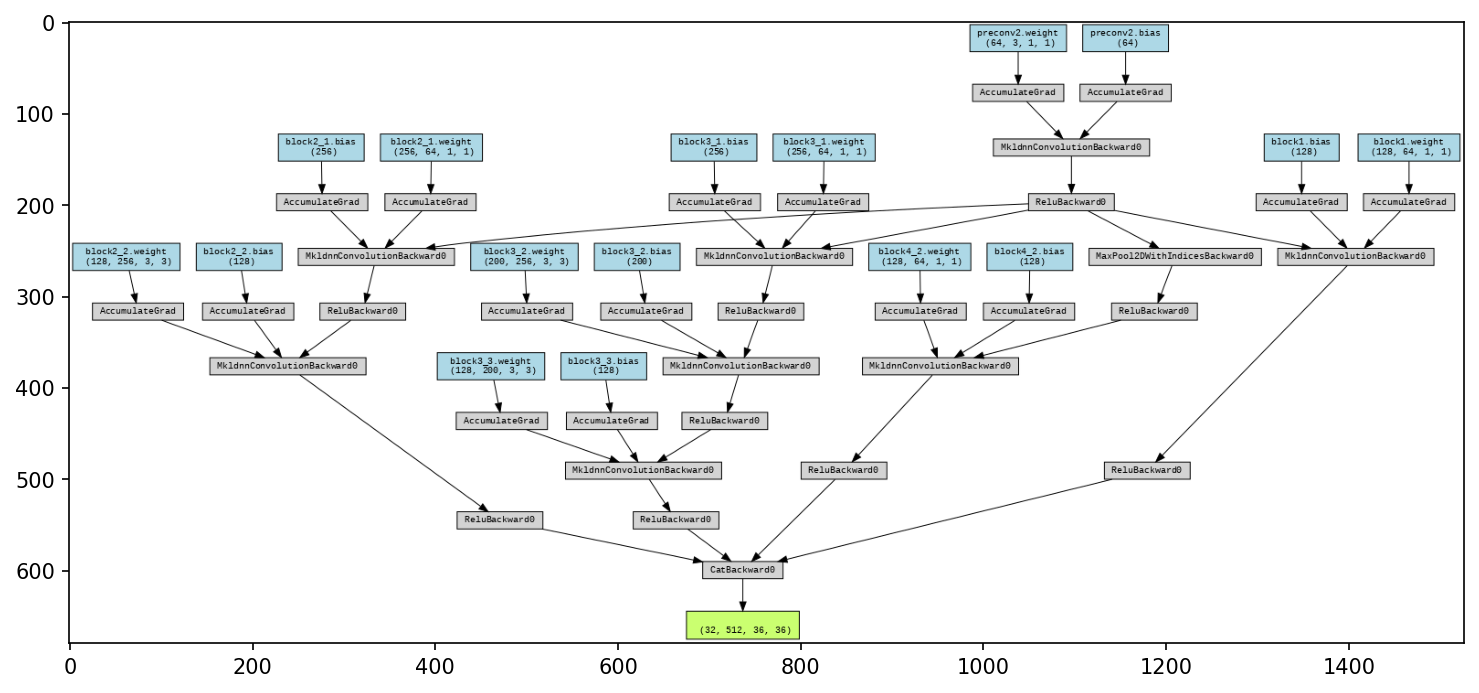

In [ ]:
class inception_module(nn.Module):
  def __init__(self, input_channels = 3):
    super(inception_module, self).__init__()

    self.preconv2 = torch.nn.Conv2d(in_channels = input_channels, out_channels=64, kernel_size=1, stride=1, padding=1)

    self.block1 = torch.nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=1, stride=1, padding=1)

    self.block2_1 = torch.nn.Conv2d(in_channels = 64, out_channels=256, kernel_size=1, stride=1, padding=1)
    self.block2_2 = torch.nn.Conv2d(in_channels = 256, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.block3_1 = torch.nn.Conv2d(in_channels = 64, out_channels=256, kernel_size=1, stride=1, padding=1)

    self.block3_2 = torch.nn.Conv2d(in_channels = 256, out_channels=200, kernel_size=3, stride=1, padding=1)
    self.block3_3 = torch.nn.Conv2d(in_channels = 200, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.block4_1 = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.block4_2 = torch.nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=1, stride=1, padding=1)

  def forward(self, x):
    x = F.relu(self.preconv2(x))
    b1 = x
    b2 = x
    b3 = x
    b4 = x

    b1 = F.relu(self.block1(b1))
    b2 = F.relu(self.block2_2(F.relu(self.block2_1(b2))))
    b3 = F.relu(self.block3_3(F.relu(self.block3_2(F.relu(self.block3_1(b3))))))
    b4 = F.relu(self.block4_2(F.relu(self.block4_1(b4))))

    return torch.cat((b1, b2, b3, b4), 1)

model = inception_module(3)


X = torch.randn(32, 3, 32, 32)
yh = model(X)

from torchviz import make_dot

make_dot(yh, params=dict(list(model.named_parameters()))).render("inception", format="png")

plt.figure(figsize=(12, 10), dpi=150)
plt.imshow(plt.imread("/content/inception.png"))

# Redes siamesas

## Triplet Loss  
$L(a, p, n) = max\{d(a_i, p_i)-d(a_i, n_i) + \alpha, 0\}$  
$d(x_i, y_i) = ||x_i-y_i||_p$
y $\alpha$ es el margen.

In [ ]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()
output

tensor(0.9983, grad_fn=<MeanBackward0>)

Implementación de triplet loss con Pytorch

In [ ]:
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

test_data = torchvision.datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Créditos**: El siguiente código para crear el dataset *MNIST* ha sido extraído de https://www.kaggle.com/hirotaka0122/triplet-loss-with-pytorch. Autor: Hirotaka Kawashima

In [ ]:
import random
from torch.utils.data import DataLoader, Dataset
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

Dataset https://www.kaggle.com/c/digit-recognizer/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

## Arquitectura

Pasando `Triplet_loss` a un formato adecuado para ser usado en un modelo de redes siamesas de Pytorch:

In [ ]:
class Triplet_loss(nn.Module):
  def __init__(self, margen):
    super().__init__()
    self.margen = margen
  def forward(self, anchor, positive, negative):
    dist_pos = (anchor-positive).pow(2).sum(1)
    dist_neg = (anchor-negative).pow(2).sum(1)
    max = F.relu(dist_pos-dist_neg+self.margen)
    # Es lo mismo que max(dist_pos-dist_neg+self.margen, 0)
    return max.mean()

In [ ]:
class net(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.conv1 = nn.Conv2d(input_dim, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.fc1 = nn.Linear(4*4*64, 512)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = net(1)

Se define el optimizador y la función de pérdida junto al margen

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion_loss = Triplet_loss(1.1)

model = model.to(device)

## Entrenamiento

In [ ]:
model.train()
epochs = 4
for epoch in tqdm(range(epochs), desc="Epochs"):
  rloss = []
  for step, (anchor, positive, negative, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    optimizer.zero_grad()
    anch_out = model(anchor)
    positive_out = model(positive)
    negative_out = model(negative)

    current_loss = criterion_loss(anch_out, positive_out, negative_out)

    current_loss.backward()
    optimizer.step()
    rloss.append(current_loss.item())
  print(epoch+1, rloss[epoch] )

Epochs:  25%|██▌       | 1/4 [01:18<03:54, 78.25s/it]

1 1.099968433380127



Epochs:  50%|█████     | 2/4 [02:24<02:22, 71.34s/it]

2 0.011011991649866104



Epochs:  75%|███████▌  | 3/4 [03:32<01:09, 69.64s/it]

3 0.0



Epochs: 100%|██████████| 4/4 [04:41<00:00, 70.34s/it]

4 0.13534758985042572


## Predicciones

La predicción con los datos de entrenamiento:

In [ ]:
resultados_train = []
clases = []

model.eval()
with torch.no_grad():
  for imagen, _, _, label in tqdm(train_loader):
    imagen = imagen.to(device)
    yhat = model(imagen)
    resultados_train.append(yhat.detach().cpu().numpy())
    clases.append(label)

np.array(resultados_train).shape

100%|██████████| 1313/1313 [00:52<00:00, 25.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1313,)

In [ ]:
resultados_train = np.concatenate(resultados_train)
clases = np.concatenate(clases)

In [ ]:
resultados_train.shape

(42000, 2)

In [ ]:
clases.shape

(42000,)

## Visualización

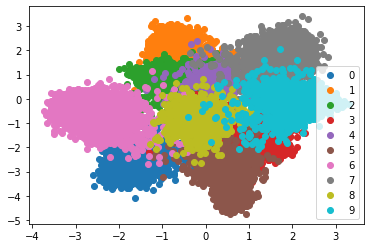

In [ ]:
for current_label in np.unique(labels):
  train_i = resultados_train[clases==current_label]
  plt.scatter(train_i[:, 0], train_i[:, 1], label=current_label)

plt.legend()
plt.show()

# Convoluciones y filtros

## Bloques Conv2D

Filtro convolucional usando bloques `Conv2D`:

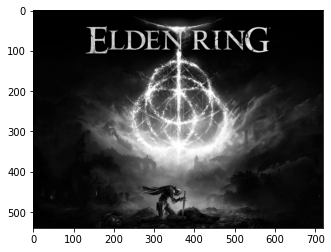

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean

img = plt.imread("elden.png")
newsize = (512, 512)
# Se reescala la imagen evitando aliasing
new = downscale_local_mean(img, (4, 4, 1))

plt.imshow(new[:, :, 0], cmap="gray")

In [ ]:
new = new[:, :, 0]
new.shape

(540, 720)

In [ ]:
new = new[..., np.newaxis]
new = new[np.newaxis, ...]
new.shape

(1, 540, 720, 1)

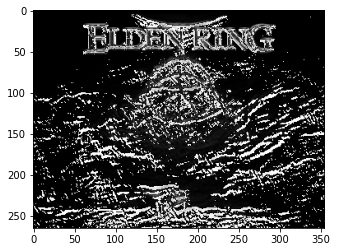

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

import tensorflow as tf

conv2d = tf.keras.layers.Conv2D(filters=3,
    kernel_size=11,
    strides=(2, 2),
    padding='valid', input_shape=new.shape)

image_conv = conv2d(new)

image_conv = tf.transpose(image_conv, perm=[1, 2, 0, 3])

out = image_conv[:, :, 0, 0]

plt.imshow((out * 255).astype(np.uint8), cmap="gray")

In [ ]:
out.shape

TensorShape([265, 355])

## Conv2DTranspose

Deconvolución o convolución transpuesta:

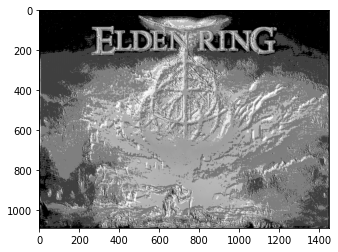

In [ ]:
conv2d_transpose = tf.keras.layers.Conv2DTranspose(filters=3,
    kernel_size=11,
    strides=(2, 2),
    padding='valid', input_shape=new.shape)

image_conv = conv2d_transpose(new)

image_conv = tf.transpose(image_conv, perm=[1, 2, 0, 3])

out = image_conv[:, :, 0, 0]

plt.imshow((out * 255).astype(np.uint8), cmap="gray")

Como puede observarse, a diferencia de la convolución (correlación) "estándar", la convolución transpuesta aumenta el tamaño.

Convolución usando un filtro específico. En concreto, el filtro gaussiano.

In [ ]:
def gaussian_kernel(kernel_size=11, sig=1.5):
    array = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2, kernel_size)
    gauss = np.exp(-0.5 * np.square(array) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

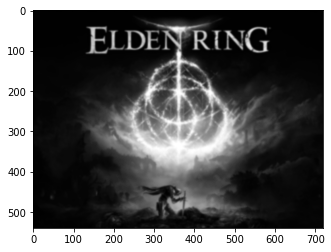

In [ ]:
conv2d = tf.nn.conv2d(new, gaussian_kernel(11).reshape((11, 11, 1, 1)), strides=[1, 1, 1, 1], padding="SAME")

image_conv = tf.transpose(conv2d, perm=[1, 2, 0, 3])

out = image_conv[:, :, 0, 0]

plt.imshow((out * 255).astype(np.uint8), cmap="gray")

## Bloques funcionales

Usando el módulo funcional, que es más apropiado para estas tareas:

In [ ]:
!wget https://i.ibb.co/WKqJD5G/1580940161570.png
!mv 1580940161570.png sample.png

--2022-04-29 10:42:12--  https://i.ibb.co/WKqJD5G/1580940161570.png
Resolving i.ibb.co (i.ibb.co)... 172.96.161.75, 172.96.160.123, 172.96.160.123
Connecting to i.ibb.co (i.ibb.co)|172.96.161.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333318 (326K) [image/png]
Saving to: ‘1580940161570.png.1’

1580940161570.png.1 100%[===================>] 325.51K   467KB/s    in 0.7s    

2022-04-29 10:42:13 (467 KB/s) - ‘1580940161570.png.1’ saved [333318/333318]



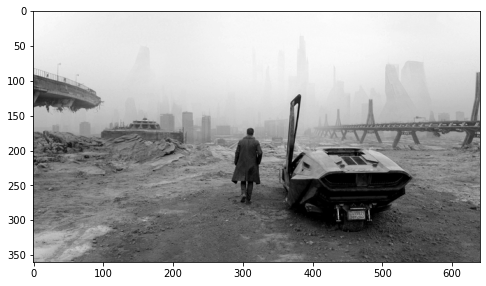

In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean

img_storm = plt.imread("sample.png")

plt.figure(figsize=(8, 6))
plt.imshow(img_storm[:, :, 0], cmap="gray")

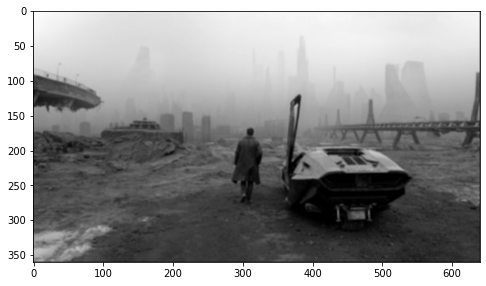

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np


img_storm_resized = img_storm[np.newaxis, ...]

# Se crea el kernel (filtro que será pasado a lo largo de la imagen) 
weight = torch.tensor([[1.,1.,1.],
                          [1.,1.,1.],
                          [1.,1.,1.]])

# Se len proporcionan las dimensiones adecuado 
weight = weight.view(1, 1, 3, 3).repeat(1, 3, 1, 1)

# Se pasa a formato pytorch (batch, channels, height width)
input = torch.permute(torch.from_numpy(img_storm_resized), (0, 3, 1, 2))

# Se le aplica la convolución a la imagen
output = F.conv2d(input=input.cuda(), weight=weight.cuda(), stride=1, padding=1).cpu()

plt.figure(figsize=(8, 6))
plt.imshow(output.permute(0, 2, 3, 1)[0, :, :, 0], cmap="gray")

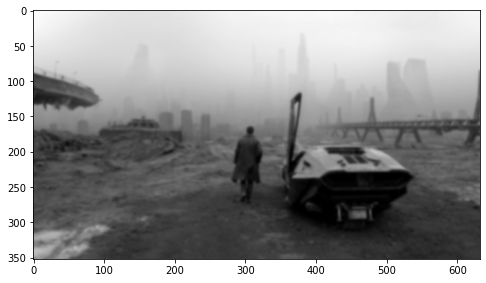

In [ ]:
# Se crea el kernel gaussiano
gkernel = torch.from_numpy(gaussian_kernel(kernel_size=11, sig=1.5)).type(torch.FloatTensor).repeat(1, 3, 1, 1)

output = F.conv2d(input=input.cuda(), weight=gkernel.cuda(), stride=1, padding=1).cpu()

plt.figure(figsize=(8, 6))
plt.imshow(output.permute(0, 2, 3, 1)[0, :, :, 0], cmap="gray")

Se ha mostrado como aplicar un filtro a una imagen concreta. No obstante, el motivo por el cual esta segunda parte se ha hecho con pytorch en lugar de con el módulo funcional de tensorflow, es porque el segundo me generaba problemas aquí, y como salida proporcionaba el siguiente error "No algorithm worked!".

# Autoencoders

Los autoencoders son una herramienta poderosa, ya que, no sólo tienen capacidades discriminativas, sino también generativas, siendo capaces de crear representaciones en el espacio latente (especialmente los variacionales). 

## Autoencoder lineal como PCA

Una de las formas más interesantes del autoencoder, es la de ser capaz de reducir la dimensionalidad de un conjunto de datos, y mediante el error de reconstrucción, obtener una aproximación de cuanto se aproxima el modelo a los datos.

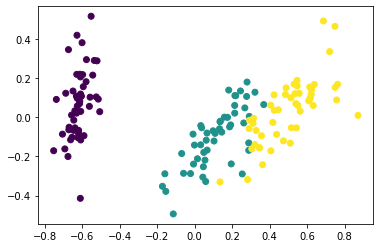

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# Se escalan los datos
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn import decomposition
# Se calcula el PCA
pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(X_scaled)

# Se muestran los datos
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=y)

In [ ]:
X.shape

(150, 4)

Epoch 1/20
5/5 [==============================] - 1s 5ms/step - loss: 0.5315
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.2054
Epoch 3/20
5/5 [==============================] - 0s 6ms/step - loss: 0.1219
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0847
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0656
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0549
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0482
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0435
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0399
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 11/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 12/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 13/20
5/5 [==============================] - 0s 5ms/step - loss: 0

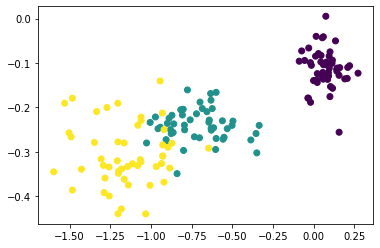

In [ ]:
# Se crea el encoder
encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(2, input_shape=[4])])
# Se crea el decoder
decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(4, input_shape=[2])])
# Se construye el autoencoder a partir del encoder y decoder
autoencoder = tf.keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_scaled, X_scaled, epochs=20)

pred = encoder.predict(X_scaled)
plt.scatter(pred[:, 0], pred[:, 1], c=y)

## Autoencoder convolucional

### Estructura básica de un autoencoder

A continuación se creará un autoencoder convolucional, para ver como varían las dimensiones de las imágenes de entrada.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class autoencoder(nn.Module):
  def __init__(self, input_shape= None):
    super().__init__()
    # Upsampling mediante la convolución
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0, stride=2)
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2)

    # Upsampling mediante la convolución transpuesta
    self.conv3 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.max = torch.nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self, x):
    print(x.shape)
    x = self.conv1(x)
    print(x.shape)
    x = self.conv2(x)
    print(x.shape)
    x = self.conv3(x)
    print(x.shape)
    x = self.conv4(x)
    print(x.shape)
    #print(x.shape)
    return x
autoencoder_ = autoencoder()
autoencoder_(torch.randn(64, 1, 28, 28))
print()

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 13, 13])
torch.Size([64, 64, 6, 6])
torch.Size([64, 32, 8, 8])
torch.Size([64, 64, 10, 10])



Se cargan los datos de entrada, que serán los de Fashion Mnist

In [ ]:
import torch
from torchvision import datasets, transforms
import helper
import numpy as np

transform = transforms.Compose([transforms.ToTensor(),])

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Se utiliza el conjunto de test, ya que al contener una menor cantidad de imágenes, acelera los cálculos.

### Aqruitectura completa

En cuanto al modelo, se crea el encoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class encoder(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=3, padding=1, stride=2)
    self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2)
    #self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1)
  def forward(self, x):
    #print(x.shape)
    x = F.relu(self.conv1(x))
    #print(x.shape)
    x = F.max_pool2d(x, 2, 2)
    #print(x.shape)
    x = F.relu(self.conv2(x))
    #print(x.shape)
    x = F.max_pool2d(x, 2, 2)
    #print(x.shape)
    #x = F.relu(self.conv3(x))
    #print(x.shape)
    return x
  
encoder_ = encoder(1)
output = encoder_(torch.randn(32, 1, 28, 28))
print()

Se crea el decoder

In [ ]:
class decoder(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.conv1 = torch.nn.ConvTranspose2d(in_channels=input_shape, out_channels=32, kernel_size=3, padding=0, stride=2)
    self.conv2 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, padding=1, stride=3)
    self.conv3 = torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, padding=1, stride=2)
  def forward(self, x):
    #print(x.shape)
    x = F.relu(self.conv1(x))
    #print(x.shape)
    x = F.relu(self.conv2(x))
    #print(x.shape)
    x = torch.tanh(self.conv3(x))
    #print(x.shape)
    return x
  
decoder_ = decoder(32)
decoder_(output)
print()

### Entrenamiento

Se crea el bloque de entrenamiento

In [ ]:
import matplotlib.pyplot as plt
import torchvision

epochs = 25
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

encoder = encoder_.to(device)
decoder = decoder_.to(device)

# Función de pérdida el MSE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001,
                             weight_decay=1e-5)

imgs = []
for epoch in range(epochs):
  loss = 0
  for img, _ in testloader:
    optimizer.zero_grad()
    img = img.to(device)
    output = decoder_(encoder_(img))
    current_loss = criterion(output, img)
  
    current_loss.backward()
    optimizer.step()
    loss += current_loss.item()

  output_numpy = output.detach().cpu().numpy()
  imgs.append(output_numpy[0, 0])

### Generación de imágenes

Se plotean las imágenes reconstruidas

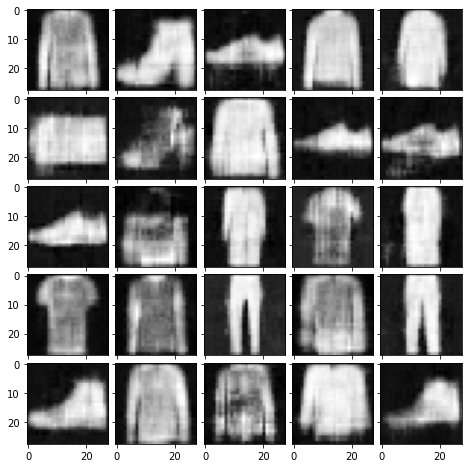

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, imgs):
    ax.imshow(im, cmap="gray")

plt.show()

## Autoencoder Variacional

En cuanto a la pérdida del AE Variancional, se usa una función de coste compuesta por el error de reconstrucción típico (entropía cruzada por ejemplo) y la pérdida latente, en este caso, la divergencia de Kullback-Leibler (KL). Esta última es una forma de medir cuanto difieren dos distribuciones probabilísticas. Por ejemplo, cuanto difierela distribución normal con los parámetros del propio VAE con respecto a la distribución normal estándar. Su forma es:  
  
  $D_{KL}[P || Q] = \frac{1}{2} \sum^n_{i=1} (1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$  
    
  y se podría modificar de la siguiente forma, mediante $\gamma = log(\sigma^2)$  
    
  $D_{KL}[P || Q] = \frac{1}{2} \sum^n_{i=1} (1+\gamma_i - \mu^{2}_i - e^{\gamma_i})$  

Donde $P$ es una distribución (la nuestra), por ejemplo $N(\mu,\sigma)$ y $Q$ es otra distribución, por ejemplo $N(0,1)$, es decir, la normal.

Pytorch ya tiene definida su propia función de pérdida KL

In [ ]:
import torch
import random
torch.manual_seed(1)

"""
Se pasa un tensor sobre la distribución log_softmax, 
que simulará los datos de la clase predicha
"""
y_pred = torch.nn.functional.log_softmax(torch.randn(10, 8, requires_grad=True), dim=-1)

"""
Se pasa un tensor sobre la distribución softmax, 
que simulará los datos de la clase real
"""
y_true = torch.nn.functional.softmax(torch.randn(10, 8, requires_grad=True), dim=-1)

# Se puede definir como
kl_divergence = torch.nn.KLDivLoss(reduction="batchmean")

kl_divergence(y_pred, y_true)

tensor(0.7963, grad_fn=<DivBackward0>)

**Créditos**: Para acortar la extensión del cuaderno y ahorrar tiempo, dado que esto es un ejemplo ilustrativo, y conceptualmente es igual, se hará el siguiente código en Keras. Se ha tomado como referencia y punto de partida, el notebook de la siguiente dirección `https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb` que pertenece al libro de `Hands-on Machine Learning`.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
class Muestreo(keras.layers.Layer):
    def call(self, inputs):
        media, logvar = inputs
        return K.random_normal(tf.shape(logvar)) * K.exp(logvar / 2) + media

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
K = keras.backend

tf.random.set_seed(42)
np.random.seed(42)

lat_dim = 15

inputs = keras.layers.Input(shape=[28, 28])

# Se crea el encoder
lat = keras.layers.Flatten()(inputs)
lat = keras.layers.Dense(200, activation="selu")(lat)
lat = keras.layers.Dense(150, activation="selu")(lat)

lat_mean = keras.layers.Dense(lat_dim)(lat)
lat_logvar = keras.layers.Dense(lat_dim)(lat)
codings = Muestreo()([lat_mean, lat_logvar])

variational_encoder = keras.models.Model(inputs=[inputs], outputs=[lat_mean, lat_logvar, codings])

# Se crea el decoder
decoder_inputs = keras.layers.Input(shape=[lat_dim])
x = keras.layers.Dense(150, activation="selu")(decoder_inputs)
#x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

means, logvar, codings = variational_encoder(inputs)
reco = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reco])

latent_loss = -0.5 * K.sum(1 + lat_logvar - K.exp(lat_logvar) - K.square(lat_mean), axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
history = variational_ae.fit(X_train, X_train, epochs=30, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/30
430/430 [==============================] - 5s 9ms/step - loss: 0.3972 - val_loss: 0.3581
Epoch 2/30
430/430 [==============================] - 4s 9ms/step - loss: 0.3525 - val_loss: 0.3611
Epoch 3/30
430/430 [==============================] - 3s 8ms/step - loss: 0.3443 - val_loss: 0.3489
Epoch 4/30
430/430 [==============================] - 3s 8ms/step - loss: 0.3394 - val_loss: 0.3410
Epoch 5/30
430/430 [==============================] - 4s 9ms/step - loss: 0.3360 - val_loss: 0.3417
Epoch 6/30
430/430 [==============================] - 3s 8ms/step - loss: 0.3334 - val_loss: 0.3341
Epoch 7/30
430/430 [==============================] - 3s 8ms/step - loss: 0.3308 - val_loss: 0.3323
Epoch 8/30
430/430 [==============================] - 3s 8ms/step - loss: 0.3285 - val_loss: 0.3282
Epoch 9/30
430/430 [==============================] - 3s 7ms/step - loss: 0.3266 - val_loss: 0.3286
Epoch 10/30
430/430 [==============================] - 3s 7ms/step - loss: 0.3251 - val_loss: 0.3274

### Generación de Imágenes

Las imágenes generadas:

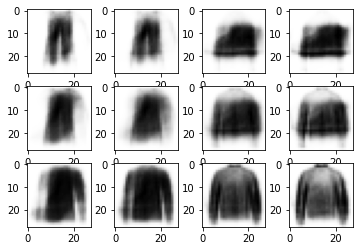

In [ ]:
import matplotlib.pyplot as plt

lat_rep = tf.random.normal(shape=[4, lat_dim])
images = variational_decoder(lat_rep).numpy()

lat_rep_grid = tf.reshape(lat_rep, [1, 2, 2, lat_dim])
larger_grid = tf.image.resize(lat_rep_grid, size=[3, 4])
interp_lat = tf.reshape(larger_grid, [-1, lat_dim])
images = variational_decoder(interp_lat).numpy()

for i, img in enumerate(images):
  plt.subplot(3, 4, i + 1)
  plt.imshow(img, cmap="binary")

## GANS

Este tipo de redes están compuestas por un generador, que es un algoritmo generativo que generar instancias mediante una distribución probabilística con el fin de poder engañar al modelo discriminativo, que usualmente, es un modelo que calcula la probabilidad de que determinada instancia pertenezca al conjunto de entrenamiento, y no sea una generada por el algoritmo generador.  
  
  Guarda cierta similitud con los algoritmos que usan técnicas adversarias con el fin de hacer más robustos los modelos hacia problemas del mundo real, donde un algoritmo como **FGSM** realiza pequeñas modificaciones capaces de engañar a los algoritmos discriminativos.

Además, los autores mencionan la inicialización aleatoria de los pesos mediante el uso de una distribución normal con media 0 y desviación típica de 0.02.

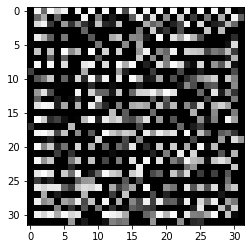

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

dim_vector_latente = 128

generador = nn.Sequential(
    nn.ConvTranspose2d( dim_vector_latente, 512, 2, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 64, 2, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.Tanh()
)

discriminador = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(dim_vector_latente),
    nn.Sigmoid()
)

z = discriminador(torch.rand(1, 3, 64, 64))

img_z = generador(z)

plt.imshow(img_z.detach().numpy()[0, 0, ...], cmap="gray")

y se crearían los optimizadores:

In [ ]:
disc_optimizador = torch.optim.Adam(discriminador.parameters(), lr=0.001, betas=(0.1, 0.999))
gen_optimizador = torch.optim.Adam(generador.parameters(), lr=0.001, betas=(0.1, 0.999))

Con los componentes descritos, se tienen los ingredientes suficientes como para poder construir un modelo basado en DCGANS.